In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils import data

# Import moving MNIST

In [2]:
Moving_MNIST = np.load('data/mnist_test_seq.npy')
Moving_MNIST = Moving_MNIST / 255
Moving_MNIST.shape

(20, 10000, 64, 64)

# Give `torch` the data

In [3]:
# Making into PyTorch tensor
Moving_MNIST_tensor = torch.from_numpy(Moving_MNIST)

# Putting the existing dimensions into appropriate order
Moving_MNIST_tensor = Moving_MNIST_tensor.permute(1, 0, 2, 3)

# Added the acknowledge that this is 1 spectral band
Moving_MNIST_tensor = Moving_MNIST_tensor.unsqueeze(2)

# Checking shape
Moving_MNIST_tensor.shape

torch.Size([10000, 20, 1, 64, 64])

# Train/test split

In [4]:
train_indices = np.random.choice(range(10000), size = 8000, replace = False)

test_indices = [index for index in range(10000) if index not in train_indices.tolist()]

# Separating $x$ (first $10$ in each sequence) and $y$ (last $10$ in each sequence)

In [12]:
def sep_x_y(tensor_to_separate):
    x = []
    y = []
    for i in range(len(tensor_to_separate)):
        current_seq = tensor_to_separate[i, :, :, :, :]
        for j in range(current_seq.shape[0]):
            if j >= 10:
                current_x = current_seq[(j-10):j].numpy()
                x.append(current_x)
                current_y = current_seq[j].unsqueeze(dim = 0).numpy()
                y.append(current_y)
    x = np.asarray(x)
    x = torch.from_numpy(x).type(torch.FloatTensor)
    y = np.asarray(y)
    y = torch.from_numpy(y).type(torch.FloatTensor)
    return(x, y)

In [47]:
x, y = sep_x_y(Moving_MNIST_tensor[train_indices])
x_test, y_test = sep_x_y(Moving_MNIST_tensor[test_indices])

MemoryError: 

# Viewing the overlaid $(x, y)$ sequences

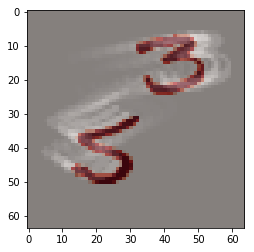

In [53]:
random_index = np.random.choice(len(x_test))

for i in range(10):
    plt.imshow(x_test[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
plt.imshow(y_test[random_index, 0, 0], cmap = 'Reds', alpha = 0.5);

# Defining the model

In [7]:
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, GPU):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        self.GPU         = GPU
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        to_return = (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)),
                     Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)))
        if self.GPU:
            to_return = (to_return[0].cuda(), to_return[1].cuda())
        return(to_return)


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first, bias, return_all_layers, GPU):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.GPU = GPU

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias,
                                          GPU=self.GPU))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [8]:
# Picking one of the like-sequence tensors within the list to set parameters
channels = x.shape[2]
height = x.shape[3]
width = x.shape[4]

In [9]:
conv_lstm = ConvLSTM(input_size = (height,
                                   width),
                     input_dim = channels,
                     hidden_dim = [128, 64, 64, 1],
                     kernel_size = (5, 5),
                     num_layers = 4,
                     batch_first = True,
                     bias = True,
                     return_all_layers = False,
                     GPU = True)

In [10]:
conv_lstm.cuda()

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(129, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(65, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

# Training

In [11]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(conv_lstm.parameters(),
                                lr = 10**(-3),
                                alpha = 0.9)

In [12]:
class train_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x[IDs, :, :, :, :]
        curr_y = y[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)
    
class test_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x_test[IDs, :, :, :, :]
        curr_y = y_test[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)

In [13]:
training_set = train_Dataset(data_indices=range(y.shape[0]))
testing_set = test_Dataset(data_indices=range(y_test.shape[0]))

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = training_set,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = testing_set,
                                          batch_size = batch_size,
                                          shuffle = True)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
conv_lstm = torch.nn.DataParallel(conv_lstm)

In [16]:
loss_list = []
loss_list_test = []
epochs = int(np.ceil((7*10**5) / x.shape[0]))
data_exs = 0
for i in range(epochs):
    for data in train_loader:
        
        # data loader
        batch_x, batch_y = data
        #batch_x_test, batch_y_test = next(iter(test_loader))
        
        # move to GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #batch_x_test = batch_x_test.to(device)
        #batch_y_test = batch_y_test.to(device)
        
        # run model and get the prediction
        batch_y_hat = conv_lstm(batch_x)
        batch_y_hat = batch_y_hat[0][0]
        #batch_y_hat_test = conv_lstm(batch_x_test)
        #batch_y_hat_test = batch_y_hat_test[0][0]
        
        # calculate and store the loss
        batch_loss = loss(batch_y, batch_y_hat)
        loss_list.append(batch_loss.item())
        #batch_loss_test = loss(batch_y_test, batch_y_hat_test)
        #loss_list_test.append(batch_loss_test.item())
        
        # update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    print('Epoch: ', i, '\n\tBatch loss: ', batch_loss.item(), '\n')

Epoch:  0 
	Batch loss:  0.04019565507769585 

Epoch:  1 
	Batch loss:  0.04068833217024803 

Epoch:  2 
	Batch loss:  0.03907826542854309 

Epoch:  3 
	Batch loss:  0.03684207797050476 

Epoch:  4 
	Batch loss:  0.03609519079327583 

Epoch:  5 
	Batch loss:  0.039396751672029495 

Epoch:  6 
	Batch loss:  0.03826717287302017 

Epoch:  7 
	Batch loss:  0.037398774176836014 

Epoch:  8 
	Batch loss:  0.03674032911658287 

Epoch:  9 
	Batch loss:  0.03734317049384117 

Epoch:  10 
	Batch loss:  0.0362115278840065 

Epoch:  11 
	Batch loss:  0.03638283535838127 

Epoch:  12 
	Batch loss:  0.038067497313022614 

Epoch:  13 
	Batch loss:  0.03902849927544594 

Epoch:  14 
	Batch loss:  0.037183526903390884 

Epoch:  15 
	Batch loss:  0.036692410707473755 

Epoch:  16 
	Batch loss:  0.03582322224974632 

Epoch:  17 
	Batch loss:  0.03470247611403465 

Epoch:  18 
	Batch loss:  0.036947328597307205 

Epoch:  19 
	Batch loss:  0.03765515610575676 

Epoch:  20 
	Batch loss:  0.03703098371624946

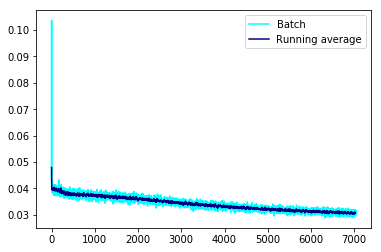

In [17]:
plt.plot(loss_list,
         color = 'cyan',
         label = 'Batch')
plt.plot(np.convolve(loss_list, 1/10*np.ones(10))[10:-10],
         color = 'navy',
         label = 'Running average')
plt.legend();

In [18]:
#plt.plot(loss_list_test,
#         color = 'pink',
#         label = 'Test batch')
#plt.plot(np.convolve(loss_list_test, 1/10*np.ones(10))[10:-10],
#         color = 'red',
#         label = 'Test running average')
#plt.legend();

# Getting random predictions for the test set

In [19]:
rand_x, rand_y = next(iter(test_loader))

rand_y_hat = conv_lstm(rand_x.to(device))[0][0][0]
rand_y_hat = rand_y_hat.cpu().data.numpy()

# Viewing random predictions for the test set

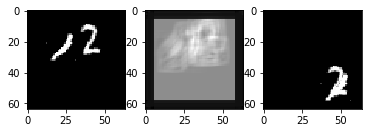

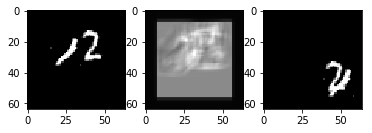

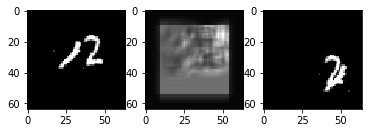

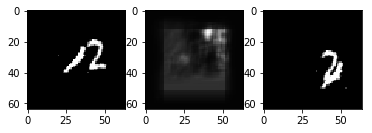

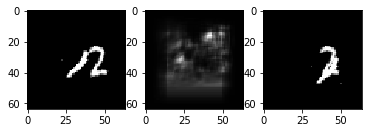

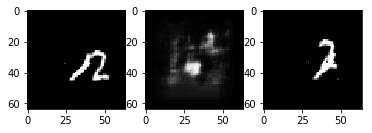

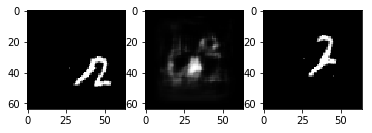

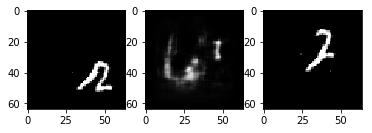

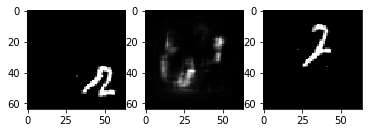

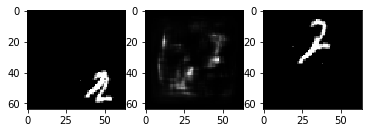

In [20]:
for i in range(rand_y_hat.shape[0]):
    f, axarr = plt.subplots(1, 3)
    f.set_figheight(3)
    f.set_figwidth(6)
    axarr[0].imshow(rand_x[0, i, 0], cmap = 'gist_gray')
    axarr[1].imshow(rand_y_hat[i, 0], cmap = 'gist_gray')
    axarr[2].imshow(rand_y[0, i, 0], cmap = 'gist_gray')